<a href="https://colab.research.google.com/github/mjcast94/DM2023-Lab2-Master/blob/main/Homework/TFIDF_NaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#allow Collaboratory access to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#necessary access to folders and libraries
import os
folder_path = '/content/drive/MyDrive/Colab Notebooks/dm2023-isa5810-lab2-homework'
os.chdir(folder_path)

##necessary library requirements
import pandas as pd
import numpy as np
import json

Mounted at /content/drive


In [ ]:
#load json file
tweets_data = []

with open('/content/drive/MyDrive/Colab Notebooks/dm2023-isa5810-lab2-homework/tweets_DM.json', 'r', encoding='utf-8') as file:
    for line in file:
        tweet = json.loads(line)
        tweets_data.append({
            'tweet_id': tweet['_source']['tweet']['tweet_id'],
            'text': tweet['_source']['tweet']['text']
        })


tweets_df = pd.DataFrame(tweets_data)
print(tweets_df.head())

   tweet_id                                               text
0  0x376b20  People who post "add me on #Snapchat" must be ...
1  0x2d5350  @brianklaas As we see, Trump is dangerous to #...
2  0x28b412  Confident of your obedience, I write to you, k...
3  0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>
4  0x2de201  "Trust is not the same as faith. A friend is s...


In [ ]:
#combine emotion,identification, and json files
f1 = pd.read_csv('data_identification.csv')
f2 = pd.read_csv('emotion.csv')
merged_df = pd.merge(f1, f2, on='tweet_id', how='left')

print(merged_df.head())

dt_all = pd.merge(tweets_df,merged_df, on='tweet_id', how='left')
print(dt_all.head())


#print(train_df.head())
#print(test_df.head())

   tweet_id identification emotion
0  0x28cc61           test     NaN
1  0x29e452          train     joy
2  0x2b3819          train     joy
3  0x2db41f           test     NaN
4  0x2a2acc          train   trust
   tweet_id                                               text identification  \
0  0x376b20  People who post "add me on #Snapchat" must be ...          train   
1  0x2d5350  @brianklaas As we see, Trump is dangerous to #...          train   
2  0x28b412  Confident of your obedience, I write to you, k...           test   
3  0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>          train   
4  0x2de201  "Trust is not the same as faith. A friend is s...           test   

        emotion  
0  anticipation  
1       sadness  
2           NaN  
3          fear  
4           NaN  


In [ ]:
#clean text column
import re
from string import punctuation
def preprocess_text(text):
  text = text.lower()
  text = re.sub(f"[{re.escape(punctuation)}]","",text)
  text=" ".join(text.split())
  return text

dt_all['text'] = dt_all['text'].map(preprocess_text)

dt_all[:10]

,tweet_id,text,identification,emotion
0,0x376b20,people who post add me on snapchat must be deh...,train,anticipation
1,0x2d5350,brianklaas as we see trump is dangerous to fre...,train,sadness
2,0x28b412,confident of your obedience i write to you kno...,test,NaN
3,0x1cd5b0,now issa is stalking tasha 😂😂😂 lh,train,fear
4,0x2de201,trust is not the same as faith a friend is som...,test,NaN
5,0x1d755c,riskshow thekevinallison thx for the best time...,train,joy
6,0x2c91a8,still waiting on those supplies liscus lh,train,anticipation
7,0x368e95,love knows no gender 😢😭 lh,train,joy
8,0x249c0c,dstvngcare dstvng more highlights are being sh...,train,sadness
9,0x218443,when do you have enough when are you satisfied...,test,NaN


In [ ]:
#split into testing and training datasets
train_df = dt_all.loc[dt_all['identification'] == 'train']
test_df = dt_all.loc[dt_all['identification'] != 'train']

In [ ]:
#save to pickle file
train_df.to_pickle("train_df.pkl")
test_df.to_pickle("test_df.pkl")

In [ ]:
## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

In [ ]:
# group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

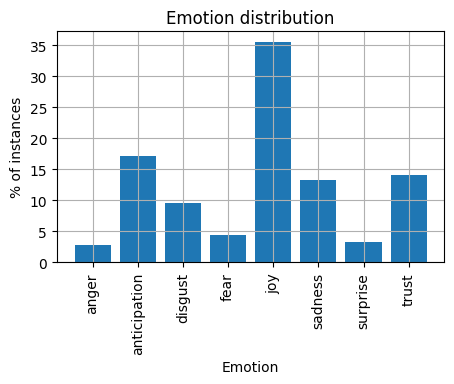

In [ ]:
#plot emotion distribution

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.xticks(rotation=90)
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

In [ ]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (1455563, 4)
Shape of Testing df:  (411972, 4)


In [ ]:
#word2vec
!pip install gensim
from gensim.models import Word2Vec
#from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

W2V_token = [word_tokenize(sentence.lower()) for sentence in train_df['text']]
W2V_model = Word2Vec(sentences=W2V_token, vector_size=100, window=5, min_count=1, epochs=20)


# Training the Word2Vec model
W2V_model.train(W2V_token, total_examples=len(W2V_token), epochs=10)

# Save the trained model to a file
W2V_model.save("word2vec_model.bin")

word_vector = W2V_model.wv['word']
print("Vector representation of 'word':", word_vector)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Vector representation of 'word': [-2.1944835  -1.9224032  -0.88162076 -1.7166065   1.3169228  -1.479018
 -2.187314   -1.0836266  -3.1079772   0.89050066 -3.909759   -0.12184223
 -3.894853   -1.8789719  -0.77750486  0.65427035 -0.9729454   0.09104881
 -1.3165468   0.90823615 -1.0542963   1.9001346  -5.154746   -0.32713774
 -1.8939254  -2.5957098   2.6715357  -1.8155802   0.24998768  0.43764573
  0.8577968   1.2904004  -2.1080198   0.9865698  -2.1565187   2.9822001
  0.02711313  4.059575   -3.6603005  -4.985404   -1.1490172   1.0497787
  0.9571976  -0.3950535   3.1709764  -0.04464068  0.71447164  0.7180689
  0.97691065 -1.78465     0.7538432  -1.6098974  -2.9945173  -2.5081315
  1.3660955  -2.9602113   1.5938649  -2.0835824   1.0770607   0.5182609
  1.5635047  -0.06777369 -1.2669647   4.9633737  -1.9302231  -3.7054148
  1.6183543   1.3082252  -2.770693   -1.8788712  -1.1584522  -0.67622876
  2.0810342   1.6081115  -2.6321242  -1.8796303  -2.0959826   0.03692089
  0.38057035  0.58379936  

In [ ]:
#TF-IDF and tkenizer
#libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from nltk.tokenize import TweetTokenizer

#tweet tokenizer
def tkenizer(text):
  tt= TweetTokenizer()
  return tt.tokenize(text)

# build analyzers (TF-IDF)
TF_vectorizer = TfidfVectorizer(min_df=20, max_df=0.95, ngram_range=(1,1), stop_words='english', tokenizer=tkenizer).fit(train_df['text'])

# training and testing data
X_train_NB = TF_vectorizer.transform(train_df['text'])
#Y_train_NB = train_df['emotion']

#Y_test_NB = test_df['emotion'] #all will be NaN

#print(train_df.shape)
#print(test_df.shape)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
#split train and test data
from sklearn.model_selection import train_test_split

X_train, X_test,Y_train,Y_test = train_test_split(X_train_NB, train_df['emotion'], test_size=0.2, random_state=1)

#build Naives Bayes Model
NB_model = MultinomialNB()
NB_model.fit(X_train, Y_train)

train_pred = NB_model.predict(X_train)
test_pred = NB_model.predict(X_test)

#prediction results
#test_pred[:10]

In [ ]:
# accuracy
acc_train_NB = accuracy_score(y_true=Y_train, y_pred=train_pred)
acc_test_NB = accuracy_score(y_true=Y_test, y_pred=test_pred)

print('training accuracy: {}'.format(round(acc_train_NB, 2)))
print('testing accuracy: {}'.format(round(acc_test_NB, 2)))

## precision, recall, f1-score,
print(classification_report(y_true=Y_test, y_pred=test_pred))

## check by confusion matrix
CM_NB = confusion_matrix(y_true=Y_test, y_pred=test_pred)
print(CM_NB)


training accuracy: 0.54
testing accuracy: 0.53
              precision    recall  f1-score   support

       anger       0.81      0.12      0.22      7906
anticipation       0.63      0.46      0.53     49966
     disgust       0.47      0.34      0.40     27443
        fear       0.81      0.28      0.42     12937
         joy       0.50      0.87      0.63    103695
     sadness       0.50      0.44      0.47     38562
    surprise       0.79      0.13      0.22      9541
       trust       0.61      0.20      0.30     41063

    accuracy                           0.53    291113
   macro avg       0.64      0.36      0.40    291113
weighted avg       0.57      0.53      0.49    291113

[[  981   330  1293    41  3677  1462     9   113]
 [   21 23048  1118   128 22203  2075    73  1300]
 [   66   865  9409   165 10569  5900    57   412]
 [    7   775   549  3642  6665  1084    22   193]
 [   33  5836  1832   224 89708  3252    81  2729]
 [   75  1362  3796   163 15769 16859    53   4

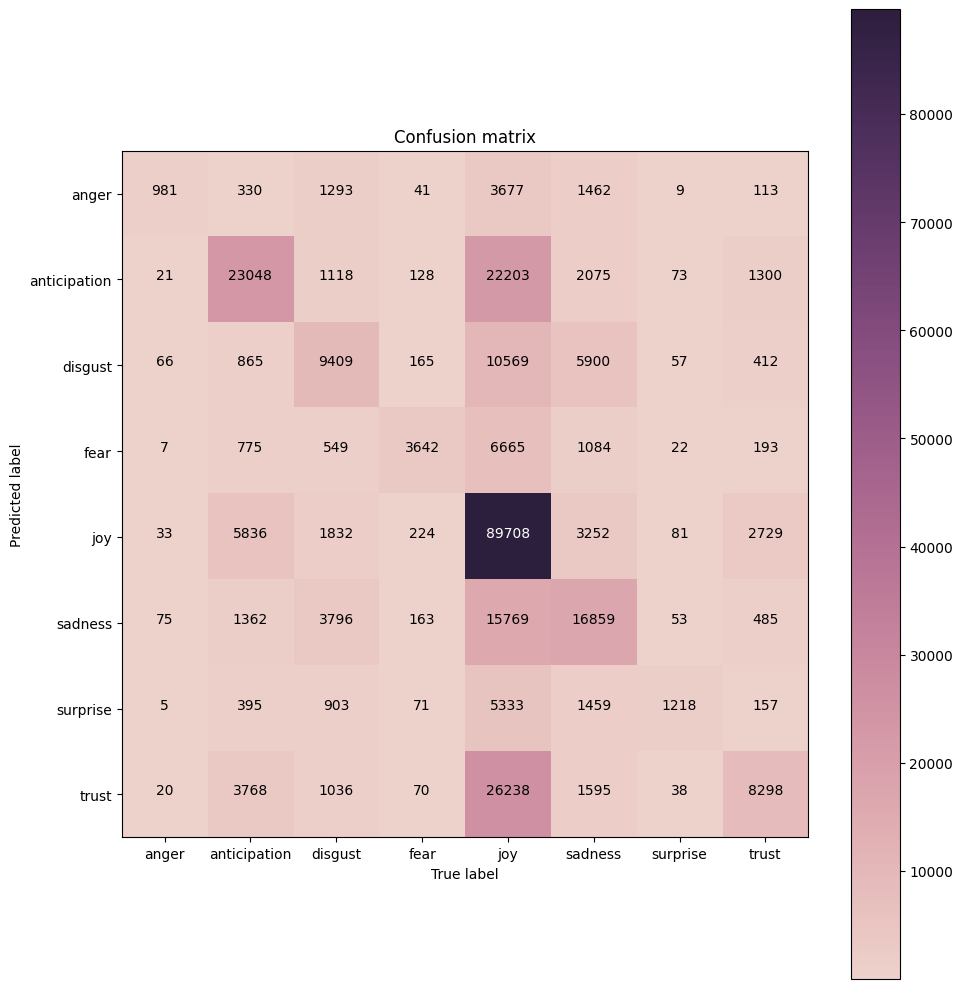

In [ ]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(CM_NB, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(CM_NB, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(CM_NB.shape[1]),
           yticks=np.arange(CM_NB.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = CM_NB.max() / 2.
    for i, j in itertools.product(range(CM_NB.shape[0]), range(CM_NB.shape[1])):
        plt.text(j, i, format(CM_NB[i, j], fmt), horizontalalignment="center", color="white" if CM_NB[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()


# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness','anticipation', 'trust', 'disgust','surprise']
plot_confusion_matrix(CM_NB, classes=my_tags, title='Confusion matrix')

In [ ]:
#predict label for test data
X_train = TF_vectorizer.transform(train_df['text'])
Y_train = train_df['emotion']
X_test = TF_vectorizer.transform(test_df['text'])

NB_model = NB_model.fit(X_train, Y_train)

predict = NB_model.predict(X_test)

#csv file with predictions
test_df['emotion'] = predict
output = test_df[['tweet_id','emotion']].copy()
output = output.set_axis(['id','emotion'],axis=1)
output.to_csv('NB_TFIDF.csv', index=False)
test_df

,tweet_id,text,identification,emotion
8909,0x2a720c,jimwhite lets have a footballleague competitio...,test,anticipation
1641858,0x37572d,ive never had someone all about metil now ❤️ lh,test,joy
844378,0x305f7c,a raise at both jobs and a promotion at one of...,test,joy
1372432,0x319900,i dont get it i dont get how people can hate h...,test,joy
60795,0x368134,the antidote to fear is faith and the soundtra...,test,anticipation
...,...,...,...,...
573964,0x2702ae,wimbledon norinchidf rogerfederer he did have ...,test,joy
877062,0x29e800,thisweekabc mcmaster seems to have had a few g...,test,sadness
1191911,0x2ff982,jaketapper your up for it its going to take ge...,test,sadness
1273782,0x284230,talldreams hmmmm r u sure its a bedtime story ...,test,sadness


In [ ]:
output

,id,emotion
8909,0x2a720c,anticipation
1641858,0x37572d,joy
844378,0x305f7c,joy
1372432,0x319900,joy
60795,0x368134,anticipation
...,...,...
573964,0x2702ae,joy
877062,0x29e800,sadness
1191911,0x2ff982,sadness
1273782,0x284230,sadness
